In [1]:
import pandas as pd
import glob
from collections import defaultdict
import numpy as np
import json


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
sns.set(style='whitegrid', palette='muted')

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
!mkdir -p plots

In [3]:
results_dir = "results/1648838189"
result_name = "5000-ce"

In [4]:
# Parameters
result_name = "100-rr"
results_dir = "results/1648827940"


In [5]:
forecast_files = glob.glob(f"{results_dir}/forecast.*.jsonl")

key_to_timestamps = defaultdict(list)
key_to_last_seqnos = defaultdict(list)
key_to_last_seqno_to_forecast = defaultdict(dict)
for path in tqdm(forecast_files):
    with open(path) as f:
        for line in f:
            loaded = json.loads(line)
            key_id = str(loaded["key_id"])
            key_to_timestamps[key_id].append(loaded["processing_time"])
            key_to_last_seqnos[key_id].append(loaded["last_seqno"])
            key_to_last_seqno_to_forecast[key_id][loaded["last_seqno"]] = loaded["forecast"]


  0%|                                                                       | 0/4 [00:00<?, ?it/s]

 25%|███████████████▊                                               | 1/4 [00:00<00:01,  2.77it/s]

 50%|███████████████████████████████▌                               | 2/4 [00:00<00:00,  2.76it/s]

 75%|███████████████████████████████████████████████▎               | 3/4 [00:01<00:00,  2.61it/s]

100%|███████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]

100%|███████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]

In [6]:
source_files = glob.glob(f"{results_dir}/source.*.jsonl")
key_to_source_series = defaultdict(list)
key_to_source_timestamps = defaultdict(list)
key_to_source_seqno = defaultdict(list)
for path in source_files:
    with open(path) as f:
        for line in tqdm(f):
            loaded = json.loads(line)
            for entry in loaded:
                key_id = str(entry["key_id"])
                key_to_source_series[key_id].append(entry["value"])
                key_to_source_timestamps[key_id].append(entry["ingest_time"])
                key_to_source_seqno[key_id].append(entry["seq_no"])


0it [00:00, ?it/s]

574it [00:00, 5738.01it/s]

1239it [00:00, 6273.26it/s]

1907it [00:00, 6457.94it/s]

2575it [00:00, 6542.67it/s]

3248it [00:00, 6607.47it/s]

3919it [00:00, 6640.14it/s]

4621it [00:00, 6763.83it/s]

5346it [00:00, 6915.63it/s]

6065it [00:00, 6998.07it/s]

6814it [00:01, 7137.92it/s]

7555it [00:01, 7220.07it/s]

8292it [00:01, 7264.60it/s]

8639it [00:01, 6923.16it/s]

In [7]:
num_forecasts = pd.DataFrame([
    {"key": k, "num_forecasts": len(v)} for k, v in key_to_last_seqnos.items()
])
num_forecasts.describe()

,num_forecasts
count,92.000000
mean,5.097826
std,3.141567
min,1.000000
25%,3.000000
50%,5.000000
75%,6.250000
max,13.000000


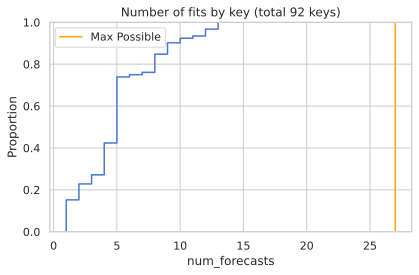

In [8]:
sns.ecdfplot(num_forecasts["num_forecasts"])
plt.title(f"Number of fits by key (total {len(num_forecasts)} keys)")
plt.axvline(27, color="orange", label="Max Possible")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/{result_name}-nfits.pdf", dpi=300)

In [9]:
num_forecasts.to_csv(f"plots/{result_name}-nfits.csv", index=None)

In [10]:
def compute_key(key):
    pred_df = (
        pd.DataFrame(
            {
                "timestamp": key_to_timestamps[key],
                "last_seqno": key_to_last_seqnos[key],
            }
        )
        .sort_values("timestamp")
        .set_index("timestamp")
    )
    true_df = (
        pd.DataFrame(
            {
                "timestamp": key_to_source_timestamps[key],
                "avg_cpu": key_to_source_series[key],
                "seq_no": key_to_source_seqno[key],
            }
        )
        .sort_values("timestamp")
        .set_index("timestamp")
    )

    merged = pd.merge_asof(
        left=true_df, right=pred_df, on="timestamp", direction="backward"
    )

    forecast = key_to_last_seqno_to_forecast[key]
    frame = pd.DataFrame(forecast)
    frame = (
        frame.T.reset_index()
        .melt("index")
        .rename(columns={"variable": "seq_delta", "index": "last_seqno"})
    )

    m = merged.dropna().reset_index(drop=True)
    m.loc[:, "seq_delta"] = (m["seq_no"] - m["last_seqno"]).astype(int)
    final = m.merge(frame, how="left", on=["last_seqno", "seq_delta"])

    mse_per_key_per_s = final.groupby(final["timestamp"].astype(int)).apply(
        lambda d: pd.Series(
            {"mse": ((d["avg_cpu"] - d["value"]) ** 2).mean(), "count": len(d)}
        )
    )
    mse_per_key_per_s["key"] = key
    return mse_per_key_per_s

with ProcessPoolExecutor() as executor:
    futs = executor.map(compute_key, key_to_timestamps.keys())
    mses = list(futs)

In [11]:
# we are dropping some keys here :sigh:
# need to figure out how to handle a key that's never fitted
# final length 4965 for 5000
all_mse = pd.concat([f.reset_index() for f in mses if len(f)])

In [12]:
all_mse.to_parquet(f"plots/{result_name}-all_mse.pq", index=None)

In [13]:
mse_by_timestamp = all_mse.groupby("timestamp").apply(
    lambda d: (d["mse"]*d["count"]).sum()/(d["count"].sum())
)

In [14]:
mse_by_timestamp.index = mse_by_timestamp.index-mse_by_timestamp.index.min()

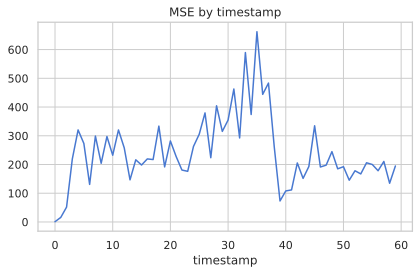

In [15]:
mse_by_timestamp.plot()
plt.title("MSE by timestamp")
plt.tight_layout()
plt.savefig(f"plots/{result_name}-mse-time.pdf", dpi=300)
mse_by_timestamp.to_csv(f"plots/{result_name}-mse-time.csv", index=True)